<a href="https://colab.research.google.com/github/patil-yasshh/projects/blob/main/Copy_of_Customer_Satisfaction_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset Shape: (8469, 17)
Columns:
 ['Ticket ID', 'Customer Name', 'Customer Email', 'Customer Age', 'Customer Gender', 'Product Purchased', 'Date of Purchase', 'Ticket Type', 'Ticket Subject', 'Ticket Description', 'Ticket Status', 'Resolution', 'Ticket Priority', 'Ticket Channel', 'First Response Time', 'Time to Resolution', 'Customer Satisfaction Rating']

Detected text columns: ['Ticket Subject', 'Ticket Description']
Detected date columns: ['Date of Purchase', 'First Response Time', 'Time to Resolution']

Train samples: 2215
Test samples: 554
Final Training Feature Shape: (2215, 518)

--- Classification Metrics ---
Accuracy: 0.18953068592057762
Precision: 0.19135976113958578
Recall: 0.18953068592057762
F1 Score: 0.19030317706859126


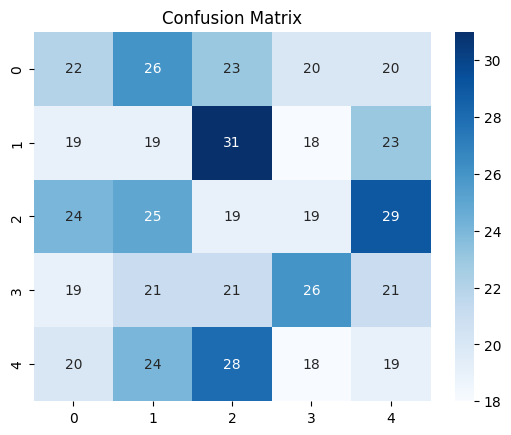

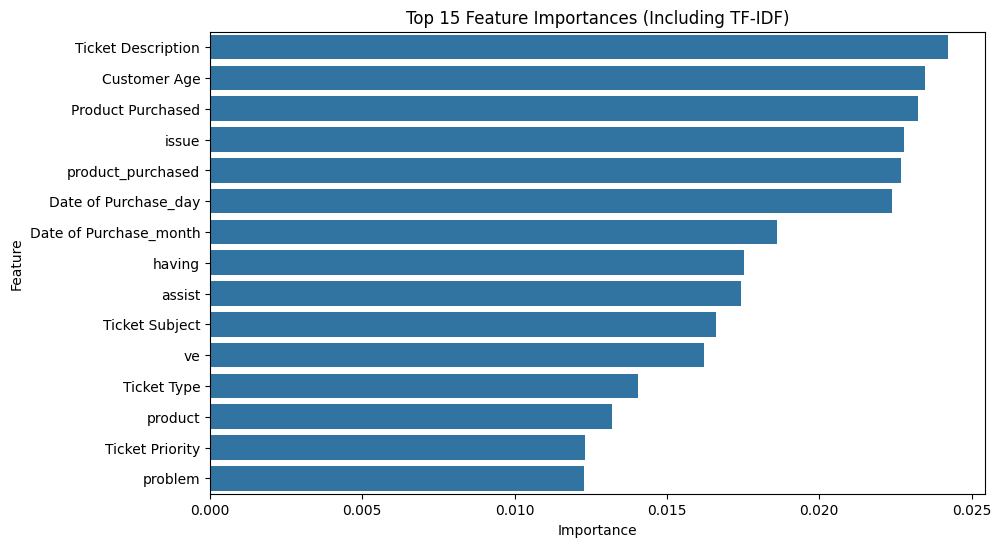


✅ Model with TF-IDF saved as 'customer_satisfaction_tfidf_model.pkl'


In [ ]:

# CUSTOMER SATISFACTION PREDICTION WITH TF-IDF TEXT ANALYSIS
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, mean_absolute_error, mean_squared_error, r2_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
import pickle

# Load Dataset

file_path = "customer_support_tickets.csv"  # <-- Change path if needed
df = pd.read_csv(file_path)

print("Dataset Shape:", df.shape)
print("Columns:\n", df.columns.tolist())

# Basic Cleaning
target_col = "Customer Satisfaction Rating"

# Drop rows missing the target
df = df.dropna(subset=[target_col])

# Identify Columns
text_cols = [c for c in df.columns if any(k in c.lower() for k in ["description", "subject", "comment", "feedback", "text"])]
date_cols = [c for c in df.columns if any(k in c.lower() for k in ["date", "time", "timestamp"])]

print("\nDetected text columns:", text_cols)
print("Detected date columns:", date_cols)

# Feature Engineering
df2 = df.copy()

# Date Features
for col in date_cols:
    df2[col] = pd.to_datetime(df2[col], errors='coerce')
    df2[f"{col}_year"] = df2[col].dt.year
    df2[f"{col}_month"] = df2[col].dt.month
    df2[f"{col}_day"] = df2[col].dt.day
    df2.drop(columns=[col], inplace=True)

# Categorical Encoding
cat_cols = df2.select_dtypes(include=['object']).columns.tolist()
cat_cols = [c for c in cat_cols if c not in text_cols and c != target_col]

le = LabelEncoder()
for col in cat_cols:
    if df2[col].nunique() <= 100:
        df2[col] = df2[col].fillna('missing').astype(str)
        df2[col] = le.fit_transform(df2[col])
    else:
        df2.drop(columns=[col], inplace=True)

# Handle Numeric Missing Values
for col in df2.select_dtypes(include=[np.number]).columns:
    df2[col] = df2[col].fillna(df2[col].median())

# Prepare Data for Model
target = df2[target_col]
df2 = df2.drop(columns=[target_col])

id_like = [c for c in df2.columns if any(k in c.lower() for k in ['id', 'email', 'name', 'phone'])]
df2 = df2.drop(columns=id_like, errors='ignore')

X_train, X_test, y_train, y_test = train_test_split(
    df2, target, test_size=0.2, random_state=42, stratify=target
)

print("\nTrain samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

#  TF-IDF Vectorization
if text_cols:
    df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1)
else:
    df['combined_text'] = ""

X_train_text = df.loc[X_train.index, 'combined_text']
X_test_text = df.loc[X_test.index, 'combined_text']

# Create TF-IDF features (you can adjust max_features for more detail)
tfidf = TfidfVectorizer(max_features=500, stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

# Convert TF-IDF to DataFrame
tfidf_df_train = pd.DataFrame(X_train_tfidf.toarray(), columns=tfidf.get_feature_names_out(), index=X_train.index)
tfidf_df_test = pd.DataFrame(X_test_tfidf.toarray(), columns=tfidf.get_feature_names_out(), index=X_test.index)

# Merge numeric/categorical features with TF-IDF text features
X_train_final = pd.concat([X_train.reset_index(drop=True), tfidf_df_train.reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test.reset_index(drop=True), tfidf_df_test.reset_index(drop=True)], axis=1)

print("Final Training Feature Shape:", X_train_final.shape)

# Model Training (Random Forest)
for col in X_train_final.columns:
    if X_train_final[col].dtype == 'object':
        X_train_final[col] = X_train_final[col].astype(str).fillna('missing')
        le = LabelEncoder()
        X_train_final[col] = le.fit_transform(X_train_final[col])

for col in X_test_final.columns:
    if X_test_final[col].dtype == 'object':
        X_test_final[col] = X_test_final[col].astype(str).fillna('missing')
        le = LabelEncoder()
        X_test_final[col] = le.fit_transform(X_test_final[col])
if target.nunique() <= 10:
    model = RandomForestClassifier(n_estimators=300, random_state=42)
else:
    model = RandomForestRegressor(n_estimators=300, random_state=42)

model.fit(X_train_final, y_train)
y_pred = model.predict(X_test_final)

# Evaluation
if target.nunique() <= 10:
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    print("\n--- Classification Metrics ---")
    print("Accuracy:", acc)
    print("Precision:", prec)
    print("Recall:", rec)
    print("F1 Score:", f1)

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()
else:
    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print("\n--- Regression Metrics ---")
    print("MAE:", mae)
    print("RMSE:", rmse)
    print("R²:", r2)

# Feature Importance Visualization
importances = pd.Series(model.feature_importances_, index=X_train_final.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=importances.head(15), y=importances.head(15).index)
plt.title("Top 15 Feature Importances (Including TF-IDF)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

#  Save Model and TF-IDF Vectorizer
with open("customer_satisfaction_tfidf_model.pkl", "wb") as f:
    pickle.dump({"model": model, "tfidf": tfidf, "features": X_train_final.columns.tolist()}, f)

print("\n✅ Model with TF-IDF saved as 'customer_satisfaction_tfidf_model.pkl'")
